<a href="https://colab.research.google.com/github/ntettero/pollob/blob/main/test_3_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.3 MB/s eta 0:00:00


In [3]:
# importing libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from tqdm import tqdm

In [4]:
#use tqdm to track progress of the apply function
tqdm.pandas()  

In [5]:
# load training_text data
df = pd.read_csv('/content/drive/MyDrive/POLLOB/last_50000.csv', index_col=0)

In [6]:
# loops over the text in the text column and applies BeautifulSoup to split text based on the html tags
text_fragments = []
for text in df['text']:
    soup = BeautifulSoup(text, 'html.parser')
    for sentence in soup.get_text().split('.'):
        if sentence.strip():
            text_fragments.append({'text': sentence.strip()})

In [8]:
# cleaned df with text that was split with html tag in a new row
cleaned_text = pd.DataFrame(text_fragments)

In [21]:
df.iloc[0]['text']

'<span>ik weet niet of ik u goed heb begrepen, minister. wilt u het totale plaatje bekijken en het debat over de lerarenloopbaan en de lesopdrachten in zijn geheel aangaan, en ondertussen niet overgaan tot het nemen van gemakkelijke maatregelen zoals de invoering van dat één uur extra? als dat zo is, dan ben ik opgelucht. het zou wijs zijn om niet snel dergelijke maatregelen te nemen en dan de zaken maar op hun beloop te laten. ik zeg niet dat u dat laatste wilt, maar ik ben er wel alert voor.</span></p><span>ik herinner eraan dat men in het verleden heeft voorgesteld om de mentoruren af te schaffen, met de toevoeging dat er een ander, beter stelsel in de plaats zou komen. maar dat betere stelsel is er nooit gekomen. wij wachten nog steeds op de begeleiding voor beginnende leerkrachten. ik hoop dus dat u de zaken in hun geheel bekijkt, en niet nu al maatregelen neemt die de opdrachten van de leerkrachten nog zullen verzwaren.</span></p>'

In [12]:
cleaned_text.head()
len(cleaned_text)

415667

In [14]:
# Create a new DataFrame to store the exploded text fragments
exploded_df = pd.DataFrame()

# Iterate over each row in the original DataFrame
for idx, row in df.iterrows():
    text = row['text']
    soup = BeautifulSoup(text, 'html.parser')
    fragments = []
    
    # Extract text fragments from HTML and split into sentences
    for sentence in soup.get_text().split('.'):
        if sentence.strip():
            fragments.append(sentence.strip())
    
    # Create a temporary DataFrame with exploded text fragments
    temp_df = pd.DataFrame({'text': fragments})
    
    # Repeat the values of other columns for each exploded fragment
    for col in df.columns:
        if col != 'text':
            temp_df[col] = row[col]
    
    # Concatenate the temporary DataFrame to the exploded_df
    exploded_df = pd.concat([exploded_df, temp_df], ignore_index=True)
    
    # Display the iteration number
    print(f"Iteration: {idx+1}/{len(df)}")

# Display the exploded DataFrame
print(exploded_df)

Streaminguitvoer ingekort tot de laatste 5000 regels.
Iteration: 45094/50000
Iteration: 45095/50000
Iteration: 45096/50000
Iteration: 45097/50000
Iteration: 45098/50000
Iteration: 45099/50000
Iteration: 45100/50000
Iteration: 45101/50000
Iteration: 45102/50000
Iteration: 45103/50000
Iteration: 45104/50000
Iteration: 45105/50000
Iteration: 45106/50000
Iteration: 45107/50000
Iteration: 45108/50000
Iteration: 45109/50000
Iteration: 45110/50000
Iteration: 45111/50000
Iteration: 45112/50000
Iteration: 45113/50000
Iteration: 45114/50000
Iteration: 45115/50000
Iteration: 45116/50000
Iteration: 45117/50000
Iteration: 45118/50000
Iteration: 45119/50000
Iteration: 45120/50000
Iteration: 45121/50000
Iteration: 45122/50000
Iteration: 45123/50000
Iteration: 45124/50000
Iteration: 45125/50000
Iteration: 45126/50000
Iteration: 45127/50000
Iteration: 45128/50000
Iteration: 45129/50000
Iteration: 45130/50000
Iteration: 45131/50000
Iteration: 45132/50000
Iteration: 45133/50000
Iteration: 45134/50000
Ite

In [22]:
exploded_df.to_csv('/content/drive/MyDrive/POLLOB/exploded_df.csv')

In [6]:
exploded_df = pd.read_csv('/content/drive/MyDrive/POLLOB/exploded_df.csv')

<ipython-input-6-30a18bbfd5bf>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  exploded_df = pd.read_csv('/content/drive/MyDrive/POLLOB/exploded_df.csv')


In [7]:
sample_df = exploded_df[-10000:]

In [10]:
# DTAI
#load robbertje tokenizer and model from huggingface
tokenizerDTAI = AutoTokenizer.from_pretrained("DTAI-KULeuven/robbertje-merged-dutch-sentiment")
modelDTAI = AutoModelForSequenceClassification.from_pretrained("DTAI-KULeuven/robbertje-merged-dutch-sentiment")

def sentiment_score_DTAI(text):
    tokens = tokenizerDTAI.encode(text, return_tensors='pt')
    result = modelDTAI(tokens)
    return int(torch.argmax(result.logits))+1

sample_df['sentiment_score_DTAI'] = sample_df['text'].progress_apply(lambda x: sentiment_score_DTAI(x))

100%|██████████| 10000/10000 [10:33<00:00, 15.78it/s]
<ipython-input-10-fe9194958eab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['sentiment_score_DTAI'] = sample_df['text'].progress_apply(lambda x: sentiment_score_DTAI(x))


In [12]:
sample_df.tail()

,Unnamed: 0,text,verg_id,id_fact,journaallijn_id,titel,onderwerp,result_thema_1,result_thema_2,result_thema_3,...,sprekertitel,persoon_id,voornaam,achternaam,geslacht,geboortedatum,geboorteplaats,naam,zetel_aantal,sentiment_score_DTAI
415662,415662,dat lijkt mij vooral billijk en dat lijkt mij ...,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,...,Maxim Veys (sp·a),4428.0,Maxim,Veys,M,1987-05-06,Gent,sp·a,13.0,1
415663,415663,(applaus bij sp,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,...,Maxim Veys (sp·a),4428.0,Maxim,Veys,M,1987-05-06,Gent,sp·a,13.0,1
415664,415664,"a, groen en de pvda)",1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,...,Maxim Veys (sp·a),4428.0,Maxim,Veys,M,1987-05-06,Gent,sp·a,13.0,1
415665,415665,"collega veys, mag ik ook u feliciteren met uw ...",1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,...,De voorzitter,3411.0,Liesbeth,Homans,V,1973-02-16,Wilrijk (Antwerpen),N-VA,35.0,2
415666,415666,(applaus)de actuele vragen zijn afgehandeld,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,...,De voorzitter,3411.0,Liesbeth,Homans,V,1973-02-16,Wilrijk (Antwerpen),N-VA,35.0,1


In [101]:
# NLPTown
tokenizernlptown = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
modelnlptown = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

def sentiment_score(text):
    tokens = tokenizernlptown.encode(text, return_tensors='pt')
    result = modelnlptown(tokens)
    return int(torch.argmax(result.logits))+1

sample_df['sentiment_score_multi'] = sample_df['text'].progress_apply(lambda x: sentiment_score(x))

100%|██████████| 10000/10000 [21:09<00:00,  7.88it/s]
<ipython-input-101-6165ff5e20f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['sentiment_score_multi'] = sample_df['text'].progress_apply(lambda x: sentiment_score(x))


In [ ]:
#roberta
tokenizerRoberta = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
modelRoberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

def sentiment_score_roberta(text):
    tokens = tokenizerRoberta.encode(text, return_tensors='pt')
    result = modelRoberta(tokens)
    return int(torch.argmax(result.logits))+1

sample_df['sentiment_score_roberta'] = sample_df['text'].progress_apply(lambda x: sentiment_score_roberta(x))

 60%|█████▉    | 5986/10000 [16:45<19:07,  3.50it/s]

In [102]:
sample_df['sentiment_score_multi'].value_counts()

5    2672
1    2523
3    2511
4    1555
2     739
Name: sentiment_score_multi, dtype: int64

In [13]:
sample_df['sentiment_score_DTAI'].value_counts()

1    6434
2    3566
Name: sentiment_score_DTAI, dtype: int64

In [ ]:
sample_df['sentiment_score_robterta'].value_counts()

In [103]:
sample_df.head(20)

,text,verg_id,id_fact,journaallijn_id,titel,onderwerp,result_thema_1,result_thema_2,result_thema_3,result_thema_4,...,sprekertitel,persoon_id,voornaam,achternaam,geslacht,geboortedatum,geboorteplaats,naam,zetel_aantal,sentiment_score_multi
405667,die garanties bouwen we dus zeker in,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
405668,ik had eigenlijk gedacht dat iedereen heel pos...,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
405669,het kan toch niet dat men langs de ene kant mo...,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
405670,"wat we doen, is op een zorgzame wijze toelaten...",1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
405671,"ik vind dat eigenlijk een uitstekende zaak, wa...",1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
405672,(applaus bij de meerderheid),1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Minister Hilde Crevits,2789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
405673,"minister, ik dank u voor de verduidelijking",1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Allessia Claes (N-VA),4389.0,Allessia,Claes,V,1981-11-18,Hasselt,N-VA,35.0,5
405674,vlaanderen heeft inderdaad jaren gewerkt aan e...,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Allessia Claes (N-VA),4389.0,Allessia,Claes,V,1981-11-18,Hasselt,N-VA,35.0,5
405675,we kunnen ook leren uit het verleden,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Allessia Claes (N-VA),4389.0,Allessia,Claes,V,1981-11-18,Hasselt,N-VA,35.0,4
405676,er waren talrijke projecten rond ervaringsbewi...,1357705,1362962,1364413,Actuele vraag van Allessia Claes aan Hilde Cre...,over het erkennen van beroepscompetenties,Onderwijs en Vorming,Werk,NaN,NaN,...,Allessia Claes (N-VA),4389.0,Allessia,Claes,V,1981-11-18,Hasselt,N-VA,35.0,4


In [104]:
list(sample_df.columns)

['text',
 'verg_id',
 'id_fact',
 'journaallijn_id',
 'titel',
 'onderwerp',
 'result_thema_1',
 'result_thema_2',
 'result_thema_3',
 'result_thema_4',
 'result_thema_5',
 'zittingsjaar',
 'datum',
 'sprekertitel',
 'persoon_id',
 'voornaam',
 'achternaam',
 'geslacht',
 'geboortedatum',
 'geboorteplaats',
 'naam',
 'zetel_aantal',
 'sentiment_score_multi']

In [105]:
def combine_rows(df):
    grouped_df = df.groupby(['sprekertitel', 'journaallijn_id', 'verg_id', 'id_fact', 'titel', 'datum', 'naam']).agg({'sentiment_score_multi': 'mean', 'text': ' '.join}).reset_index()
    return grouped_df

In [106]:
def combine_rows_multi(df):
    df['combine'] = (df['sprekertitel'] != df['sprekertitel'].shift(1)).cumsum()
    grouped_df = df.groupby(['combine', 'sprekertitel', 'journaallijn_id', 'titel']).agg({
        'verg_id': 'first',
        'id_fact': 'first',
        'journaallijn_id': 'first',
        'titel': 'first',
        'onderwerp': 'first',
        'journaallijn_id': 'first',
        'titel': 'first',
        'onderwerp': 'first',
        'result_thema_1': 'first',
        'result_thema_2': 'first',
        'result_thema_3': 'first',
        'result_thema_4': 'first',
        'result_thema_5': 'first',
        'datum': 'first',
        'naam': 'first',
        'zetel_aantal': 'first',
        'sentiment_score_multi': 'mean',
        'text': 'first'
    }).reset_index(drop=True)
    
    return grouped_df


In [15]:
def combine_rows_DTAI(df):
    df['combine'] = (df['sprekertitel'] != df['sprekertitel'].shift(1)).cumsum()
    grouped_df = df.groupby(['combine', 'sprekertitel', 'journaallijn_id', 'titel']).agg({
        'verg_id': 'first',
        'id_fact': 'first',
        'journaallijn_id': 'first',
        'titel': 'first',
        'onderwerp': 'first',
        'journaallijn_id': 'first',
        'titel': 'first',
        'onderwerp': 'first',
        'result_thema_1': 'first',
        'result_thema_2': 'first',
        'result_thema_3': 'first',
        'result_thema_4': 'first',
        'result_thema_5': 'first',
        'datum': 'first',
        'naam': 'first',
        'zetel_aantal': 'first',
        'sentiment_score_DTAI': 'mean',
        'text': 'first'
    }).reset_index(drop=True)
    
    return grouped_df


In [107]:
combined_df = combine_rows_multi(sample_df)

<ipython-input-106-56408391ee2e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combine'] = (df['sprekertitel'] != df['sprekertitel'].shift(1)).cumsum()


In [16]:
combined_df = combine_rows_DTAI(sample_df)

<ipython-input-15-0b1f01c824a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combine'] = (df['sprekertitel'] != df['sprekertitel'].shift(1)).cumsum()


In [17]:
combined_df.tail()

,verg_id,id_fact,journaallijn_id,titel,onderwerp,result_thema_1,result_thema_2,result_thema_3,result_thema_4,result_thema_5,datum,naam,zetel_aantal,sentiment_score_DTAI,text
1227,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,None,None,2020-01-08,Groen,14.0,1.411765,"minister, u bent nu al een paar maanden minister"
1228,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,None,None,2020-01-08,None,NaN,1.526316,"nogmaals, voor de linkerzijde"
1229,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,None,None,2020-01-08,Vlaams Belang,23.0,1.500000,ik blijf erbij dat ik het jammer vind dat de v...
1230,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,None,None,2020-01-08,sp·a,13.0,1.272727,ik ben blij dat we de evaluatie uiteindelijk g...
1231,1350681,1355909,1356467,Actuele vraag van Maxim Veys aan Matthias Diep...,over het meerekenen van de inkomensvervangende...,Armoedebeleid,Welzijn en Gezin,Wonen,None,None,2020-01-08,N-VA,35.0,1.500000,"collega veys, mag ik ook u feliciteren met uw ..."


In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<ipython-input-120-0aab02f998bb>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped_data['naam'].unique()))


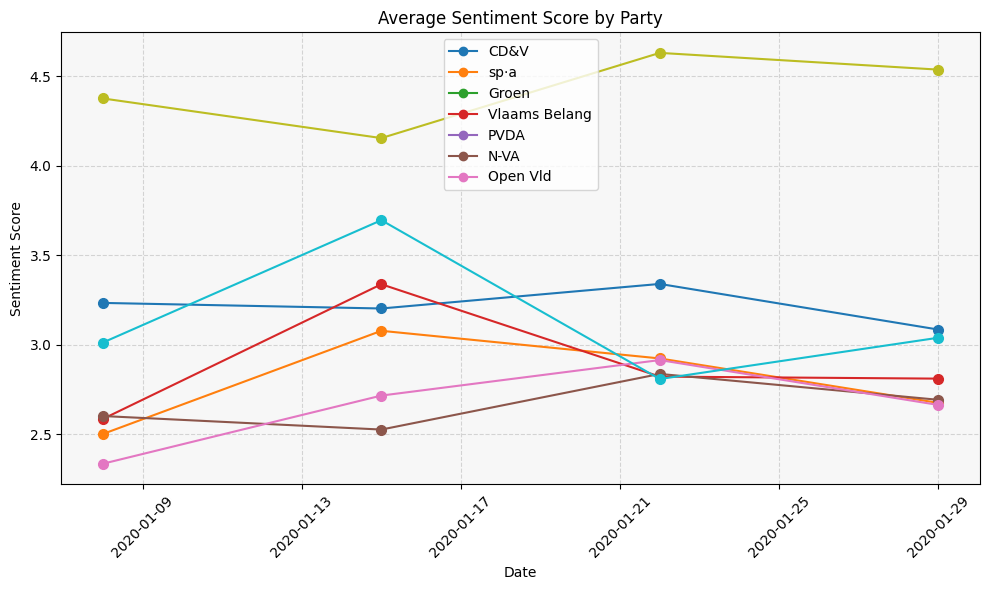

In [120]:
# Convert the 'datum' column to datetime type
combined_df['datum'] = pd.to_datetime(combined_df['datum'])

# Group the data by 'naam' and 'datum' and calculate the average sentiment score
grouped_data = combined_df.groupby(['naam', 'datum'])['sentiment_score_multi'].mean().reset_index()

# Sort the data by 'datum'
grouped_data = grouped_data.sort_values('datum')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each 'naam' and plot a line for each date
for i, name in enumerate(grouped_data['naam'].unique()):
    group = grouped_data[grouped_data['naam'] == name]
    ax.plot(group['datum'], group['sentiment_score_multi'], label=name, marker='o')

# Set plot title and axis labels
plt.title('Average Sentiment Score by Party')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')

# Format the x-axis as dates
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Adjust the layout and spacing
plt.tight_layout()

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f7f7f7')

# Customize the line colors and markers
colors = plt.cm.get_cmap('tab10', len(grouped_data['naam'].unique()))
for i, line in enumerate(ax.get_lines()):
    line.set_color(colors(i))
    line.set_markersize(7)
    line.set_markeredgewidth(1)

# Show the plot
plt.show()

<ipython-input-19-b1c5eda6b9a4>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped_data['naam'].unique()))


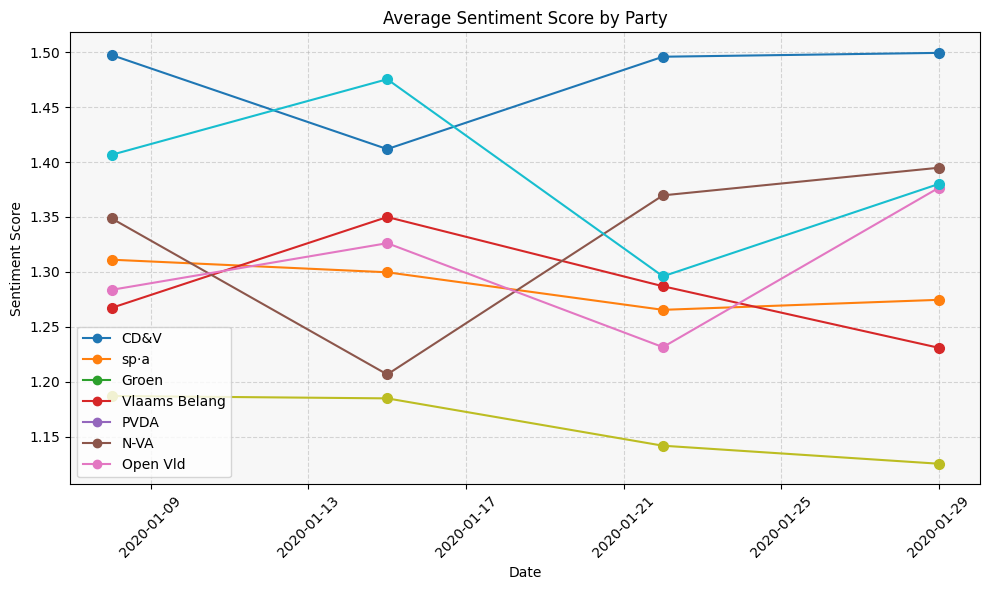

In [19]:
# Convert the 'datum' column to datetime type
combined_df['datum'] = pd.to_datetime(combined_df['datum'])

# Group the data by 'naam' and 'datum' and calculate the average sentiment score
grouped_data = combined_df.groupby(['naam', 'datum'])['sentiment_score_DTAI'].mean().reset_index()

# Sort the data by 'datum'
grouped_data = grouped_data.sort_values('datum')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each 'naam' and plot a line for each date
for i, name in enumerate(grouped_data['naam'].unique()):
    group = grouped_data[grouped_data['naam'] == name]
    ax.plot(group['datum'], group['sentiment_score_DTAI'], label=name, marker='o')

# Set plot title and axis labels
plt.title('Average Sentiment Score by Party')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')

# Format the x-axis as dates
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Adjust the layout and spacing
plt.tight_layout()

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f7f7f7')

# Customize the line colors and markers
colors = plt.cm.get_cmap('tab10', len(grouped_data['naam'].unique()))
for i, line in enumerate(ax.get_lines()):
    line.set_color(colors(i))
    line.set_markersize(7)
    line.set_markeredgewidth(1)

# Show the plot
plt.show()

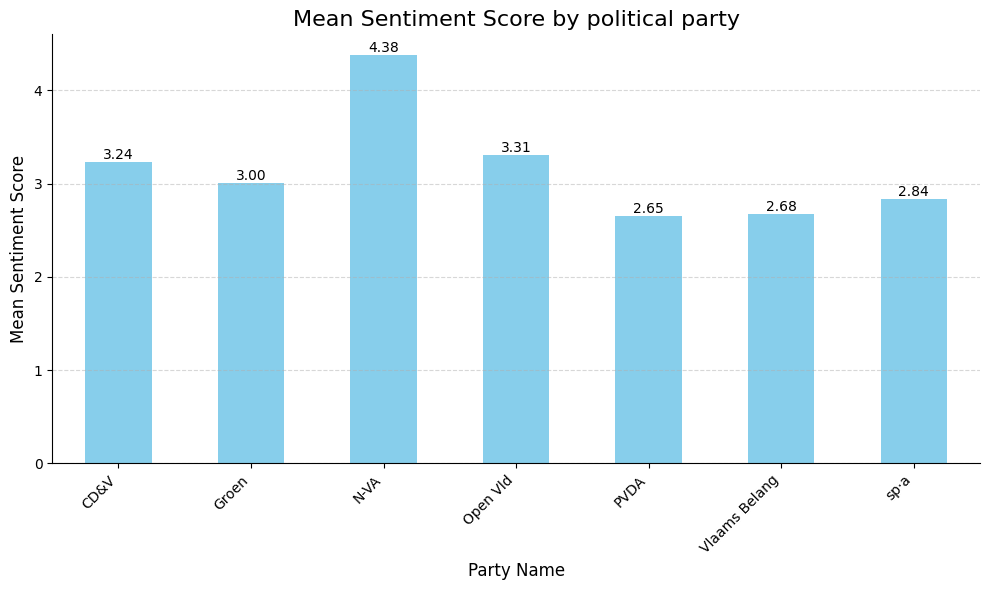

In [116]:
# Calculate the mean sentiment_score_multi for each naam
mean_scores = combined_df.groupby('naam')['sentiment_score_multi'].mean()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
mean_scores.plot(kind='bar', ax=ax, color='skyblue')

# Set plot title and axis labels
plt.title('Mean Sentiment Score by political party', fontsize=16)
plt.xlabel('Party Name', fontsize=12)
plt.ylabel('Mean Sentiment Score', fontsize=12)

# Customize the tick labels and rotation
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()